In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_feature_target(dataset, feature, transform):
    # Load data
    features_df = pd.read_csv('../training_data/' + dataset + '/features.csv')
    feature_df = features_df[feature]
    target_df = pd.read_csv('../training_data/' + dataset + '/target.csv')

    # Apply transformation
    x = transform(feature_df.to_numpy().reshape(-1, 1))
    y1 = target_df['min.log.lambda'].to_numpy()
    y2 = target_df['max.log.lambda'].to_numpy()

    # Randomly sample indices
    num_samples = 300
    indices = np.random.choice(len(x), num_samples, replace=False)

    # Select samples
    x_sampled = x[indices]
    y1_sampled = y1[indices]
    y2_sampled = y2[indices]

    # Plot
    plt.figure(figsize=(5, 5))
    plt.plot(x_sampled, y1_sampled, 'o', markeredgecolor='black', markerfacecolor='none', label='lower')
    plt.plot(x_sampled, y2_sampled, 'o', markeredgecolor='black', markerfacecolor='black', label='upper')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(dataset + " - " + feature)
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
log       = lambda x: np.log(x)
loglog    = lambda x: np.log(np.log(x))
logloglog = lambda x: np.log(np.log(np.log(x)))

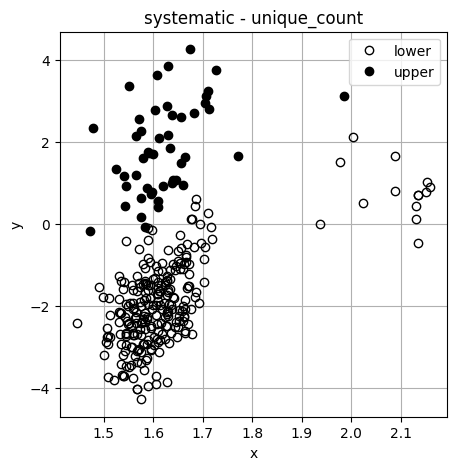

In [4]:
plot_feature_target('systematic', 'unique_count', loglog)